In [2]:
!pip install mne
!pip install pyxdf
!pip install PyWavelets
!pip install pandas 
!pip install seaborn

from tqdm import tqdm
import pyxdf
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from copy import deepcopy
from matplotlib import pyplot
import matplotlib.pyplot as plt 
from mne.decoding import Scaler
import copy
import pathlib
from pathlib import Path
from typing import Dict, List, Optional, Union
from tqdm.auto import tqdm
# import plotly.graph_objects as go
# import plotly.subplots as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

%load_ext autoreload
%autoreload 2


from utils_clean import show_streams, find_stream, get_duration, get_time_series, set_channel_names, plot_channel_correlation,detect_bad_channels,plot_bads, ica_analysis,remove_breaks,build_class_epochs_mne,create_dataset,return_dataset,plot_topo,plot_eeg,plot_evoked,standartization
# from preprocessing_1 import Preprocessing


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## **Load Data**

In [3]:
session_name = "S01"
base_path = "/Users/arnavkapur/Desktop/EEG_Speech"
data_path = os.path.join(base_path, "DATA","RAW", session_name)

xdf_file_path = os.path.join(data_path, f"{session_name}.xdf")

# Load the .xdf file
data, header = pyxdf.load_xdf(xdf_file_path)
print(f"Successfully loaded data from {xdf_file_path}")


Successfully loaded data from /Users/arnavkapur/Desktop/EEG_Speech/DATA/RAW/S01/S01.xdf


In [4]:
name = session_name
show_streams(data)
## Channel names by Antnneuro
# ch_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 
#                     'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 
#                     'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 
#                     'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 
#                     'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']

eeg_stream = find_stream('eeg', data)
marker_stream = find_stream('marker', data)
df_marker = get_time_series(marker_stream)
sfreq = float(eeg_stream["info"]["nominal_srate"][0])


Channel 0:
Effective Rate: 0
Start TimeStamp: 
Channel Name: ['79522685']
Channel Type: ['Markers']
Time Series Length: 0
--------------------
Channel 1:
Effective Rate: 0
Start TimeStamp: 
Channel Name: ['LSLTrigger']
Channel Type: ['Markers']
Time Series Shape: (924, 1)
--------------------
Channel 2:
Effective Rate: 100.00000006066404
Start TimeStamp: 
Channel Name: ['E7240457_MEMsAll']
Channel Type: ['MEMsAll']
Time Series Shape: (332800, 9)
--------------------
Channel 3:
Effective Rate: 1000.0000000529873
Start TimeStamp: 
Channel Name: ['E7240457_EEG']
Channel Type: ['EEG']
Time Series Shape: (3328000, 64)
--------------------


In [5]:
## Identify channel position for Neurable headset

channels_info = data[3]['info']['desc'][0]['channels'][0]['channel']

# Extract labels from each channel
ch_names = [channel['label'][0] for channel in channels_info]
print(len(ch_names))
print(ch_names)


64
['Fpz', 'Fp1', 'Fp2', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Pz', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'POz', 'PO3', 'PO4', 'PO5', 'PO6', 'PO7', 'PO8', 'Oz', 'O1', 'O2', 'ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL']


In [6]:
"""Create MNE file raw containing the EEG Stream"""

eeg_data = eeg_stream["time_series"].T
eeg_data = eeg_data[:64]
print(eeg_data.shape)
sfreq = float(eeg_stream["info"]["nominal_srate"][0])
eeg_info = mne.create_info(64, sfreq, ["eeg"]*64)
raw = mne.io.RawArray(eeg_data, eeg_info)
# review information
ssp_projectors = raw.info["projs"]
raw.del_proj()

(64, 3328000)
Creating RawArray with float64 data, n_channels=64, n_times=3328000
    Range : 0 ... 3327999 =      0.000 ...  3327.999 secs
Ready.


<RawArray | 64 x 3328000 (3328.0 s), ~1.59 GB, data loaded>

## **Filtering**

In [7]:

raw_highpass = raw.copy().filter(l_freq=1, h_freq=None)
raw_lowpass = raw_highpass.filter(l_freq=None, h_freq=100)
raw_notch = raw_lowpass.notch_filter(freqs=[60, 120,180])
raw_filtered = raw_notch.copy()

raw_filtered.get_data().shape



Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.9s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 133 samples (0.133 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.4s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


(64, 3328000)

New channel names: ['Fpz', 'Fp1', 'Fp2', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Pz', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'POz', 'PO3', 'PO4', 'PO5', 'PO6', 'PO7', 'PO8', 'Oz', 'O1', 'O2', 'ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL']
Using matplotlib as 2D backend.


<Figure size 640x480 with 0 Axes>

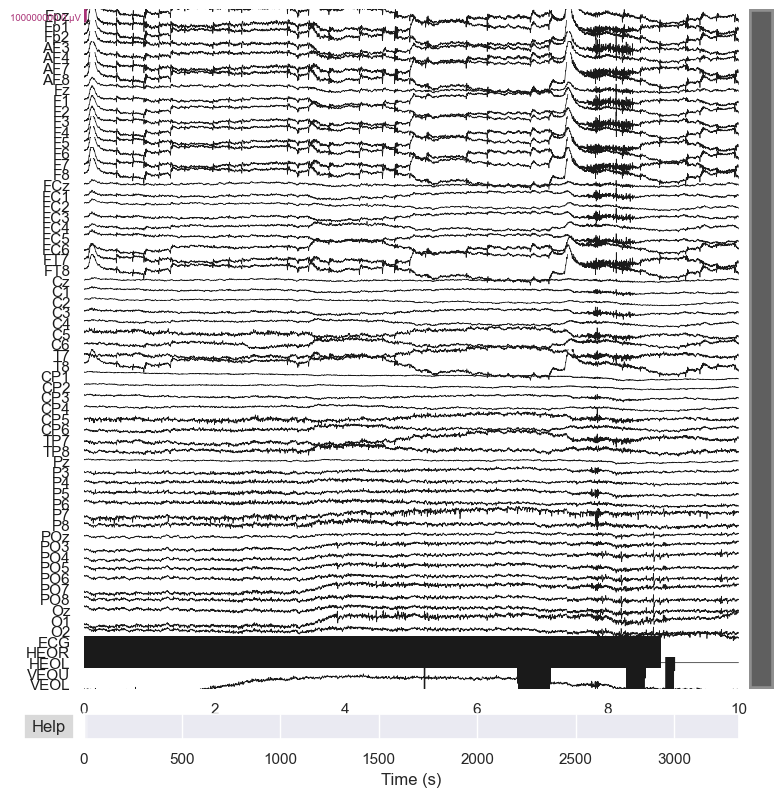

In [8]:
# Plot Raw EEG Data
plt.clf()
set_channel_names(raw,ch_names)
raw.plot(start=0, n_channels=64, scalings = {"eeg": 50})
# raw.plot(start=0, n_channels=64, scalings = "auto")

plt.show()



New channel names: ['Fpz', 'Fp1', 'Fp2', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Pz', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'POz', 'PO3', 'PO4', 'PO5', 'PO6', 'PO7', 'PO8', 'Oz', 'O1', 'O2', 'ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL']


<Figure size 640x480 with 0 Axes>

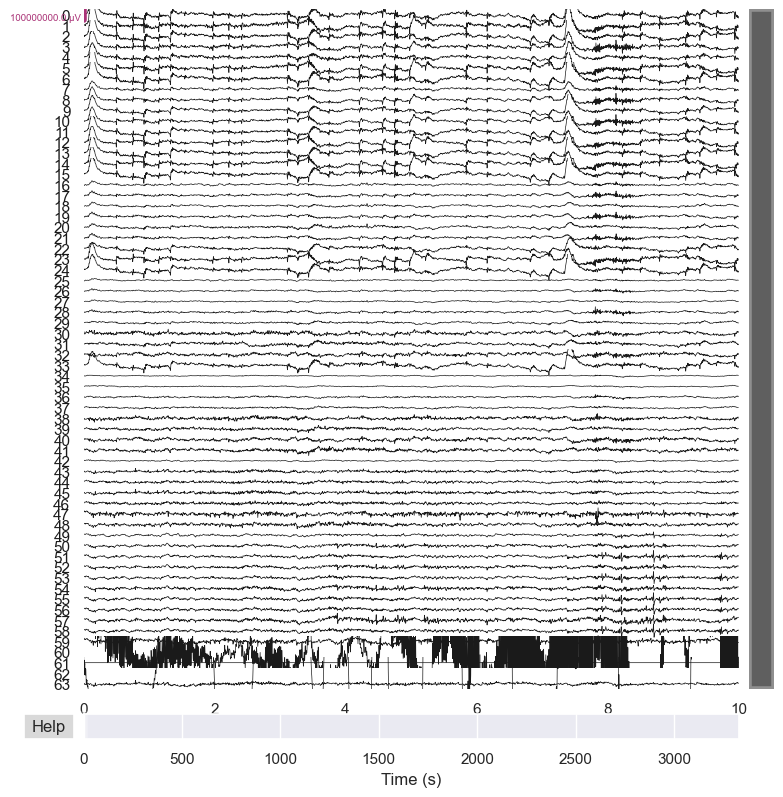

In [9]:
plt.clf()
set_channel_names(raw,ch_names)
raw_filtered.plot(start=0, n_channels=64, scalings = {"eeg": 50})
# raw.plot(start=0, n_channels=64, scalings = "auto")

plt.show()

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_10462/4098532110.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw.compute_psd(tmax=np.inf, fmax=250).plot()
/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


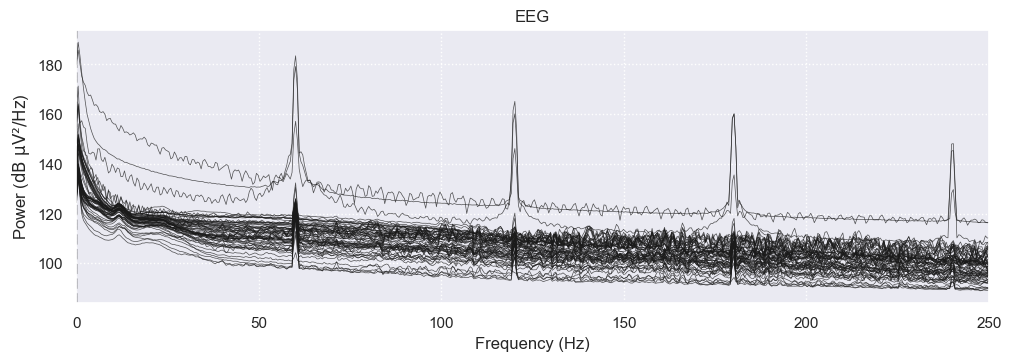

In [10]:
#  Check PSD
fig = raw.compute_psd(tmax=np.inf, fmax=250).plot()
plt.show()
# 

New channel names: ['Fpz', 'Fp1', 'Fp2', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Pz', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'POz', 'PO3', 'PO4', 'PO5', 'PO6', 'PO7', 'PO8', 'Oz', 'O1', 'O2', 'ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL']


/var/folders/w2/bjrs7bh539701pd5yx65p_cc0000gp/T/ipykernel_10462/1626480345.py:8: RuntimeWarning: DigMontage is only a subset of info. There are 5 channel positions not present in the DigMontage. The channels missing from the montage are:

['ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw_filtered.set_montage('standard_1020', on_missing='warn')


Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


/Users/arnavkapur/.pyenv/versions/3.10.12/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


<Figure size 640x480 with 0 Axes>

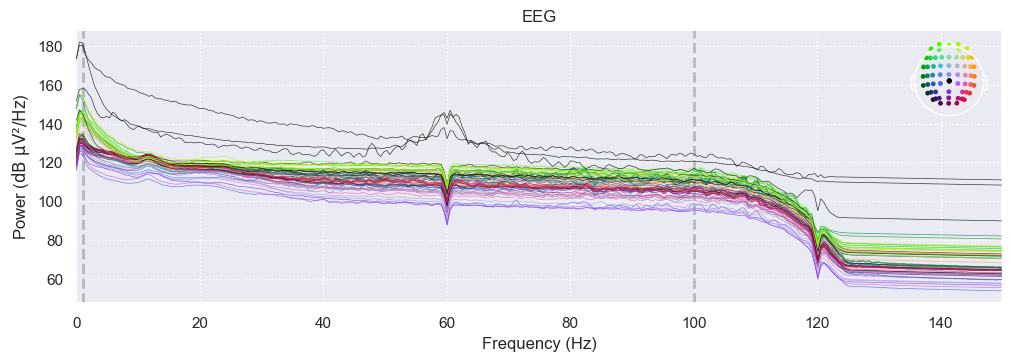

In [11]:
# # Check PSD
# fig = raw.compute_psd(tmax=np.inf, fmax=250).plot()
# plt.show()

plt.clf()
set_channel_names(raw_filtered,ch_names)

raw_filtered.set_montage('standard_1020', on_missing='warn')
raw_filtered.compute_psd(fmax=150).plot()
plt.show()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


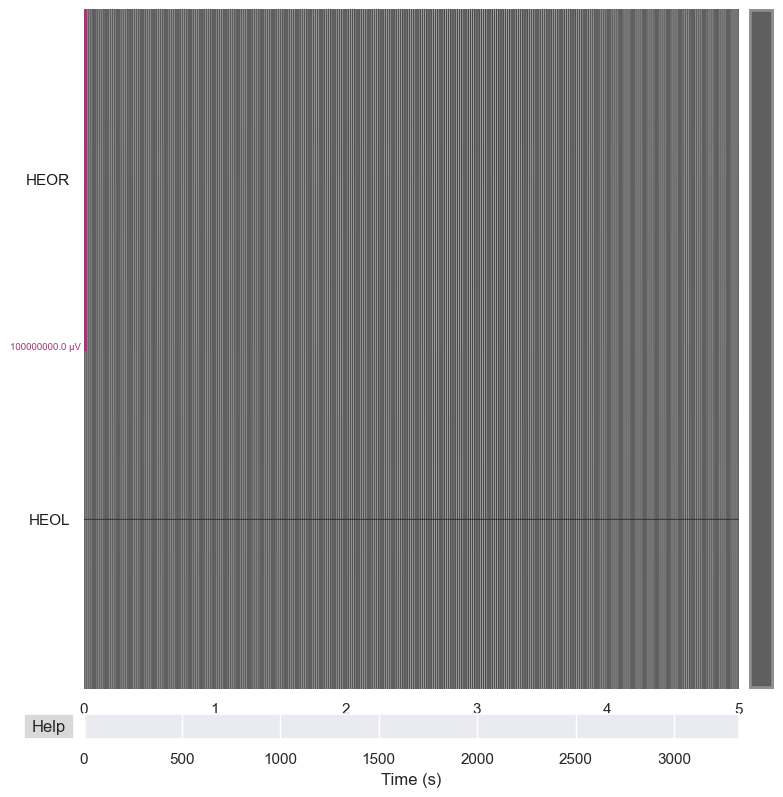

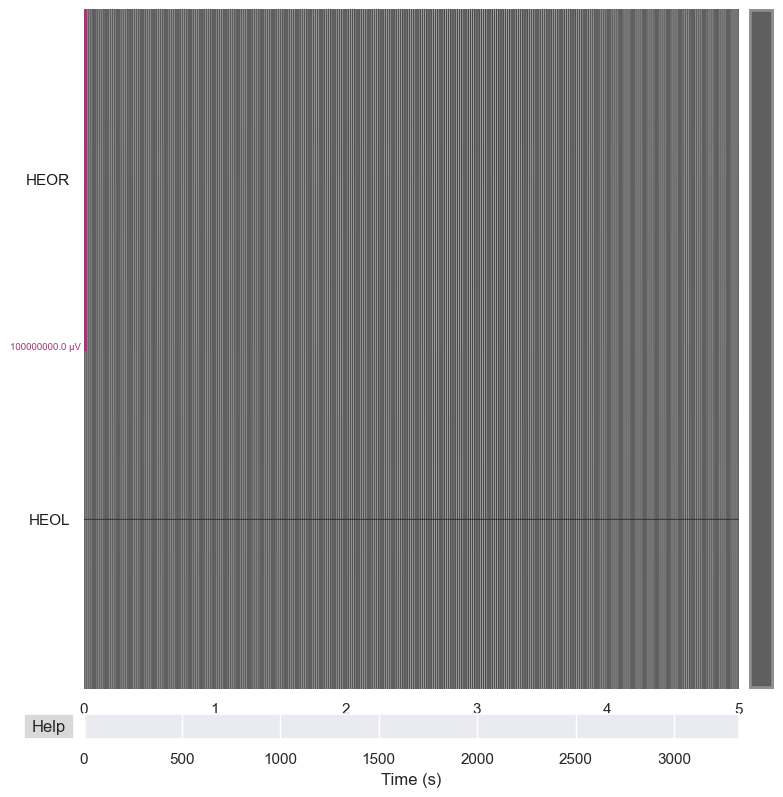

In [12]:
selected_channels = raw.copy().pick_channels(raw.ch_names[60:62])
selected_channels.plot(duration=5,title="Channels", show=True,scalings = {'eeg': 50})


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

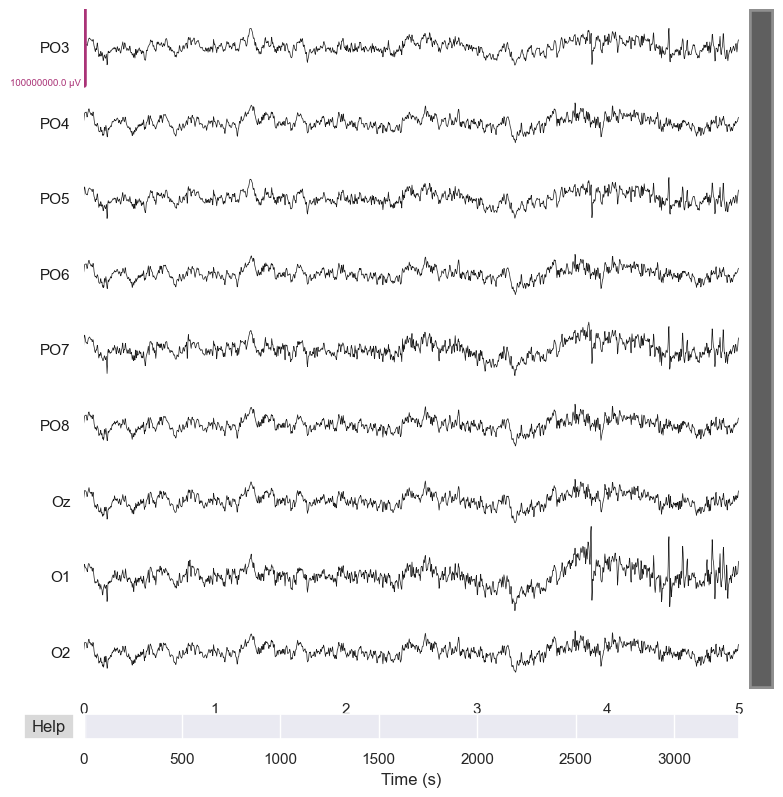

In [13]:
# Plot the selected channels
selected_channels = raw_filtered.copy().pick_channels(raw.ch_names[50:59])
# selected_channels.plot(duration=5,title="Channels 29 to 31", show=True,scalings = {'eeg': 1e-4})
plt.clf()
selected_channels.plot(duration=5,title="Channels 29 to 31", show=True,scalings = {'eeg': 50})
plt.show()

## **Bad Channel Detection**

bad channels: [30 60 61 62]
Bad channels: ['C5', 'HEOR', 'HEOL', 'VEOU']


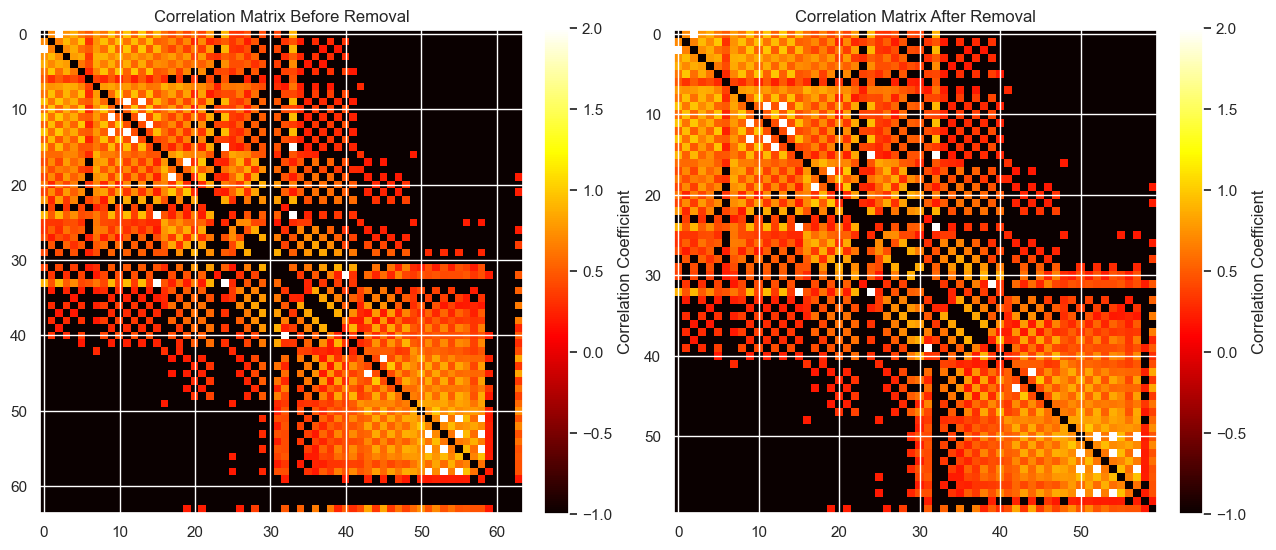

In [14]:
channel_correlation = plot_channel_correlation(raw_filtered.get_data(), ch_names)

In [15]:
bad_channels = channel_correlation[1]
bad_channels

['C5', 'HEOR', 'HEOL', 'VEOU']

In [16]:
bad_channels_2 = detect_bad_channels(raw_filtered.get_data(), ch_names)
print("Bad channels detected:", bad_channels_2)
# print("Bad channels detected:", bad_channels)

Bad channels detected: ['C5', 'HEOR', 'HEOL', 'VEOU']


In [17]:
raw_removed = raw_filtered.copy()
bad_visual = ['ECG']


In [18]:
# bad_channels = list(bad_channels)
bad_channels.extend(bad_visual)
bad_channels.extend(bad_channels_2)

raw_removed.info['bads'] = bad_channels
#raw_removed.set_montage('standard_1020', on_missing='warn')
print(raw_removed.info['bads'])

['C5', 'HEOR', 'HEOL', 'VEOU', 'ECG', 'C5', 'HEOR', 'HEOL', 'VEOU']


/Users/arnavkapur/Desktop/EEG_Speech/Speech_EEG/Preprocessing/utils_clean.py:254: RuntimeWarning: DigMontage is only a subset of info. There are 5 channel positions not present in the DigMontage. The channels missing from the montage are:

['ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw_removed.set_montage('standard_1020', on_missing='warn')


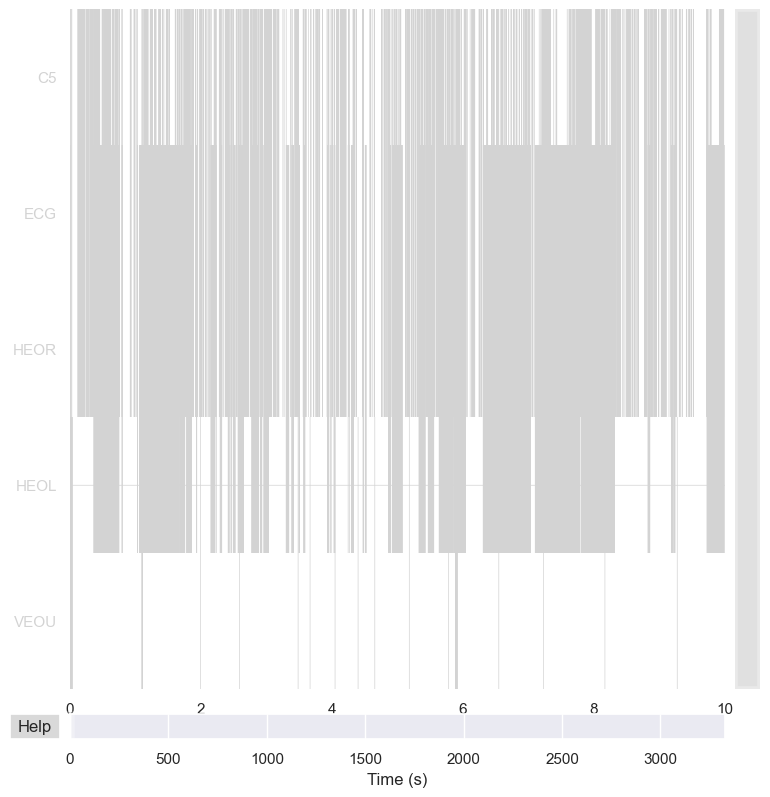

In [19]:
plot_bads(raw_removed,bad_channels)


ICA Analysis

In [20]:
ica = mne.preprocessing.ICA(n_components=10, random_state=42, max_iter="auto")
# raw_reconstructed = ica_analysis(raw_removed)


In [21]:
# plots = ica_plot(raw_removed)  

In [22]:
raw_removed

<RawArray | 64 x 3328000 (3328.0 s), ~1.59 GB, data loaded>

In [23]:
ica = mne.preprocessing.ICA(n_components=10, random_state=42, max_iter="auto")

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 108.8s.


<Figure size 640x480 with 0 Axes>

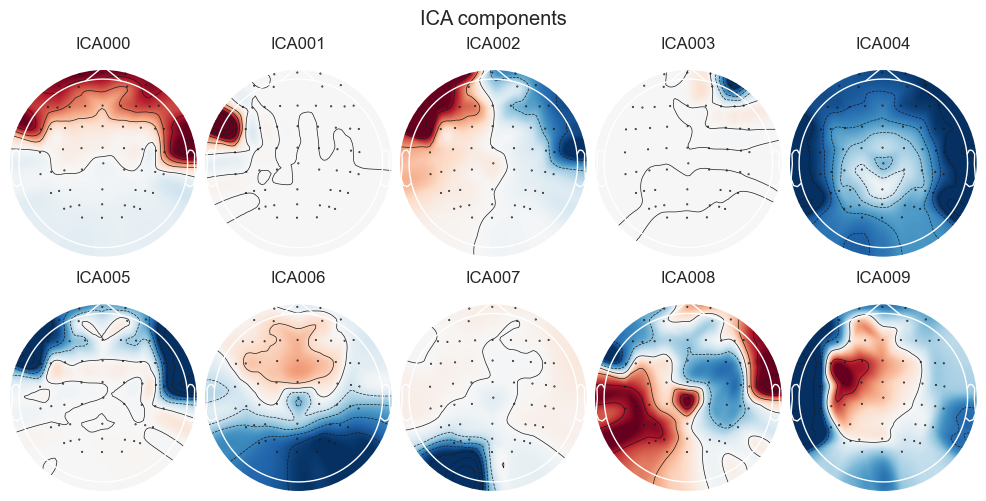

Creating RawArray with float64 data, n_channels=10, n_times=3328000
    Range : 0 ... 3327999 =      0.000 ...  3327.999 secs
Ready.


<Figure size 640x480 with 0 Axes>

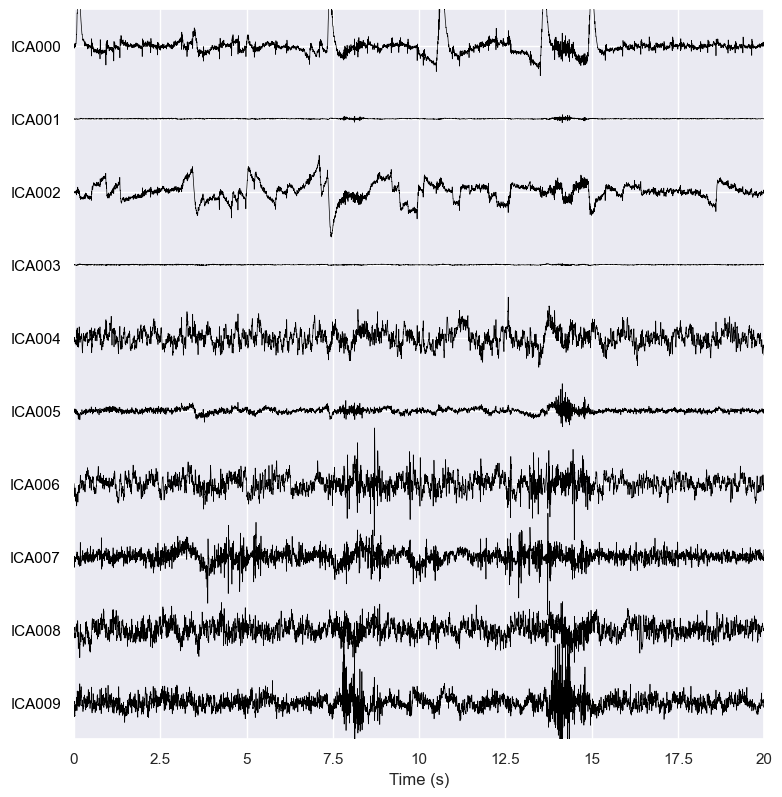

In [24]:
ica.fit(raw_removed)
plt.clf()
ica.plot_components()
plt.show()

plt.clf()
ica.plot_sources(raw_removed, show_scrollbars=False)
plt.show()

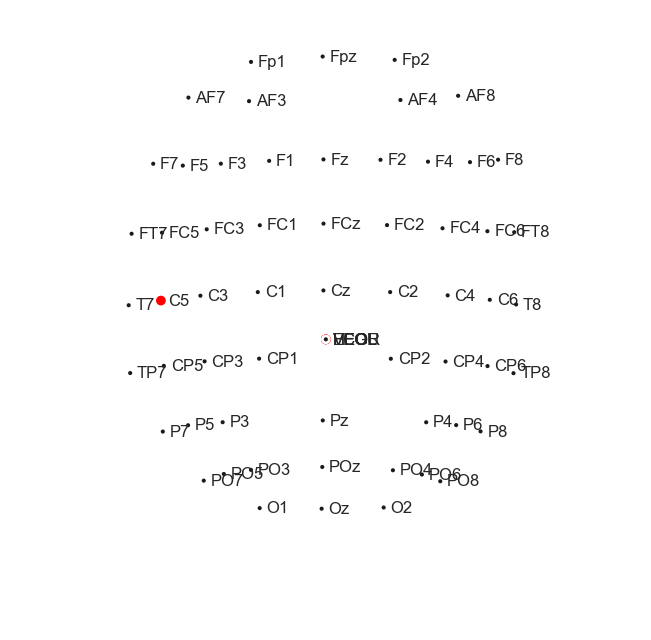

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 10 ICA components
    Projecting back using 59 PCA components


<RawArray | 64 x 3328000 (3328.0 s), ~1.59 GB, data loaded>

In [25]:
# """Select components to remove with ICA """
ica.exclude = [0,1,2,3,4,5,6,7,8,9]  # details on how we picked these are omitted here
# ica.plot_properties(raw_removed, picks=ica.exclude)

raw_removed.plot_sensors(show_names=True)
raw_reconstructed = raw_removed.copy()
ica.apply(raw_reconstructed)


<Figure size 640x480 with 0 Axes>

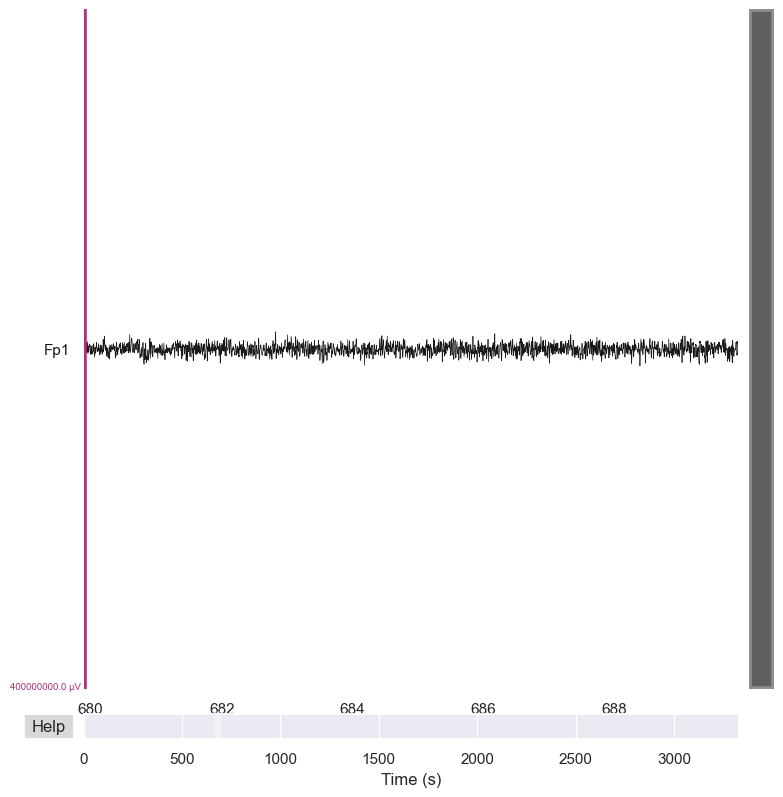

New channel names: ['Fpz', 'Fp1', 'Fp2', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Pz', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'POz', 'PO3', 'PO4', 'PO5', 'PO6', 'PO7', 'PO8', 'Oz', 'O1', 'O2', 'ECG', 'HEOR', 'HEOL', 'VEOU', 'VEOL']


<Figure size 640x480 with 0 Axes>

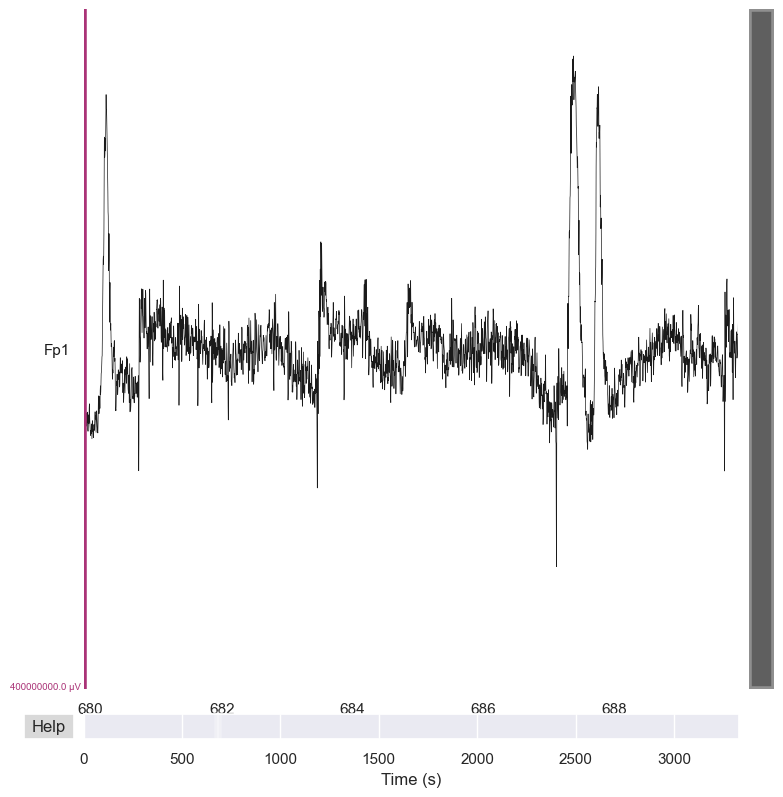

In [26]:
"compare the data fore eytracking removal before and after ICA"

eeg_start = data[3]['time_stamps'][0]
plt.clf()
raw_reconstructed.plot(start= eeg_start, picks= 'Fp1', n_channels=1, scalings={"eeg": 200})
plt.show()

plt.clf()
set_channel_names(raw_removed, ch_names)
raw_removed.plot(start=eeg_start, picks= 'Fp1', n_channels=1, scalings={"eeg": 200})
plt.show()

## **Data Labelling**

In [27]:
raw_reconstructed.get_data().shape

(64, 3328000)

Label the Data

In [28]:
print(data[1].keys())
data[1]
print(data[1]['clock_times'][0]) # marker
print(data[3]['clock_times'][0]) #eeg
print(data[1]['time_stamps'][0]) 
print(data[3]['time_stamps'][0])


dict_keys(['info', 'footer', 'time_series', 'time_stamps', 'clock_times', 'clock_values'])
2311455.90226175
2311455.90225555
2311465.920826529
679.8911178795346


## Time Offset Synchronization

In [29]:
eeg_start = data[3]['time_stamps'][0]  # EEG start time, 679.891
marker_start = data[1]['time_stamps'][0]  # Marker start time, 2311465.920826529

time_offset = data[3]['clock_times'][0] - data[1]['clock_times'][0]
aligned_marker_relative = [(ts + time_offset - marker_start + eeg_start) for ts in data[1]['time_stamps']]

aligned_pairs = []
for marker_time in aligned_marker_relative:
    closest_idx = np.argmin(np.abs(np.array(data[3]['time_stamps']) - marker_time))
    aligned_pairs.append((marker_time, data[3]['time_stamps'][closest_idx]))


In [30]:
print(len(eeg_stream['time_stamps']))
print(len(eeg_stream['clock_times']))
print(len(aligned_marker_relative))
print(len(data[1]['time_series']))

3328000
666
924
924


## Labelling

In [196]:
df_marker = pd.DataFrame(data[1]['time_series'], aligned_marker_relative,columns=['marker'])
eeg_time_series = raw_reconstructed.get_data()
eeg_time_series = eeg_time_series.T
eeg_timestamps = eeg_stream["time_stamps"]
event_time_series= marker_stream['time_series']
event_time_stamps= aligned_marker_relative

event_time_series_onset = df_marker[df_marker['marker'] == 1].reset_index()
event_time_series_offset = df_marker[df_marker['marker'] == 0].reset_index()
event_time_series_onset['numb'] = range(len(event_time_series_onset))
event_time_series_offset['numb'] = range(len(event_time_series_offset))
print("EVNETTIMESERIES", event_time_series_onset.shape)
print("EVENTTIMESERIESOFFSET", event_time_series_offset.shape)


# diff = np.subtract.outer(event_time_stamps, eeg_timestamps)
# eeg_indices = np.argmin(np.abs(diff), axis=1)
# start = eeg_indices[0] #index at which first event aligns within the EEG 

# find eeg timestamp closest to marker onset
eeg_closest_timestamps = []  

for event_time in event_time_stamps:
    closest_index = np.argmin(np.abs(eeg_timestamps - event_time))
    closest_timestamp = eeg_timestamps[closest_index]  
    eeg_closest_timestamps.append(closest_timestamp)

eeg_indeces = np.array(eeg_closest_timestamps)
print("EEG_INDICES", eeg_indeces.shape)

labels = np.empty(eeg_timestamps.shape, dtype=int)
labels.fill(900) #Fill with 900 (break)
group_labels = np.copy(labels)
trials = np.copy(labels)

start = eeg_indeces[0]
# Grab the EEG data from first event onwards and turn into dataframe
eeg_data = eeg_time_series[int(start):, :64]
out = pd.DataFrame(eeg_data, columns=ch_names)
print("OUT",out.shape)    


"Define the labels for the 5 sentences"

mark = pd.read_csv("/Users/arnavkapur/Desktop/EEG_Speech/DATA/RAW/S01/additional/137442_experiment_2024-11-05_16h38.27.560.csv")
trial_label = mark['labels']
nan_count = trial_label.isna().sum()
trial_label = trial_label.dropna().astype(int)
print(trial_label.shape)
print(trial_label)  

trial_label.index = range(len(trial_label))
event_time_series_offset['label'] = trial_label.astype(int)
event_time_series_offset = event_time_series_offset[:-1]
event_time_series_onset['label'] = trial_label.astype(int)  
event_time_series_onset = event_time_series_onset[:-1]


# Build the dataset
start_index = eeg_indeces[::2]
end_index = eeg_indeces[1::2]
start_index = start_index[:-1]
end_index = end_index[:-1]
print(start_index.shape, end_index.shape, event_time_series_onset['label'].shape) #(461,) (461,) (461,)



EVNETTIMESERIES (462, 3)
EVENTTIMESERIESOFFSET (462, 3)
EEG_INDICES (924,)
OUT (3327321, 64)
(461,)
1      4
2      2
3      1
4      0
5      3
      ..
457    4
458    1
459    3
460    2
461    2
Name: labels, Length: 461, dtype: int64
(461,) (461,) (461,)


In [198]:
sf = 1000  # Sampling frequency

durations = end_index - start_index
labels = np.full(len(eeg_timestamps),900)

for i in range(len(start_index)):
    start = np.where(eeg_timestamps[i] == start_index[i])
    if len(start) == 0:
        print(f"Start index {start_index[i]} not found in eeg_timestamps.")
        continue  

    start = start[0]  
    num_timestamps = int(durations[i] * sf)
    
    # Ensure the end index does not go out of bounds
    end_index = min(start + num_timestamps, len(eeg_timestamps))
    
    # Label the interval between start and end indices
    labels[int(start):int(end_index)] = event_time_series_onset['label'][i]

# Verify the labeling
print("Labeling complete.")
print(f"Number of timestamps labeled with '900': {np.sum(labels == 900)}")
print(f"Number of timestamps labeled: {np.sum(labels != -1)}")
print(f"Number of unlabeled timestamps: {np.sum(labels == -1)}")

# Create a DataFrame to visualize the result
df = pd.DataFrame({'time': eeg_timestamps, 'label': labels})
print(df.head())
dataset= []
df = pd.concat([pd.DataFrame({'time': eeg_timestamps, 'label': labels}), out], axis=1)
dataset.append(df)
dataset


ValueError: operands could not be broadcast together with shapes (0,) (461,) 

: 

In [178]:
import numpy as np
import pandas as pd

# Create a labels array initialized with -1 (indicating unlabeled)
labels = np.full(len(eeg_timestamps),900)

# Iterate over the start and end indices to label the timestamps
for i in range(len(start_index)):
    # Get the actual start and end times for the current interval
    start_time = start_index[i]
    end_time = (end_index[i])
    current_label = event_time_series_onset['label'][i]

    # Label all timestamps that fall within this interval
    indices_in_interval = (eeg_timestamps >= start_time) & (eeg_timestamps < end_time)
    labels[indices_in_interval] = current_label

# Verify the labeling by checking the first few and some counts
print("Labeling complete.")
print(f"Number of timestamps labeled with '900': {np.sum(labels == 900)}")
print(f"Number of timestamps labeled with other values: {np.sum(labels != -1) - np.sum(labels == 900)}")
print(f"Number of unlabeled timestamps: {np.sum(labels == -1)}")

# Create a DataFrame to visualize the result
df = pd.DataFrame({'time': eeg_timestamps, 'label': labels})
print(df.head())

# # Optionally save the labeled data for further processing
# output_path = "labeled_eeg_data.csv"
# df.to_csv(output_path, index=False)
# print(f"Labeled data saved to {output_path}")
dataset= []
df = pd.concat([pd.DataFrame({'time': eeg_timestamps[int(start):], 'label': labels[int(start):]}), out], axis=1)
dataset.append(df)
dataset

TypeError: 'int' object is not subscriptable

In [161]:
labels = np.full(len(eeg_timestamps), 900)

for i in range(len(start_index)):
    start_time = start_index[i]
    end_time = end_index[i]
    current_label = event_time_series_onset['label'][i]

    labels[(eeg_timestamps >= start_time) & (eeg_timestamps < end_time)] = current_label

dataset= []
df = pd.concat([pd.DataFrame({'time': eeg_timestamps[int(start):], 'label': labels[int(start):]}), out], axis=1)
dataset.append(df)
dataset

[                time  label       Fpz       Fp1       Fp2       AF3       AF4  \
 0         680.570118      0  2.258545  2.130037  1.645824 -4.524761 -2.218973   
 1         680.571118      0  1.466011  2.625489  1.277122 -3.904869 -1.820806   
 2         680.572118      0  0.850700  2.958233  1.055334 -3.211084 -1.704531   
 3         680.573118      0  0.464799  3.159700  0.889735 -2.482186 -1.679125   
 4         680.574118      0  0.282450  3.273463  0.671564 -1.737100 -1.484925   
 ...              ...    ...       ...       ...       ...       ...       ...   
 3327316  4007.886118    900 -0.819674  3.161940 -0.258065 -2.052926  1.025929   
 3327317  4007.887118    900 -0.785150  3.282733 -0.320688 -1.758110  0.588727   
 3327318  4007.888118    900 -0.621841  2.748673 -0.284904 -1.309776  0.275045   
 3327319  4007.889118    900 -0.341369  1.575140 -0.163066 -0.702215  0.096970   
 3327320  4007.890118    900  0.008844  0.009753  0.008722  0.006263  0.005355   
 
              

In [185]:
def print_sample_distribution(labels):
    # Count the number of samples for each label
    label_count = pd.Series(labels).value_counts().sort_index()

    # Print the number of samples per label
    print("Time sample distribution among different trials:")
    for label, count in label_count.items():
        print(f"Label {label}: {count} time samples")

# Call the function with your labels array
print_sample_distribution(labels)
sum(label_count)


Time sample distribution among different trials:
Label 0: 645137 time samples
Label 1: 642323 time samples
Label 2: 712370 time samples
Label 3: 672731 time samples
Label 4: 655439 time samples


3327321

In [163]:

# Check label distribution
label_count = df['label'].value_counts()
print(label_count)

2      1219937
3       539327
4       523673
0       508202
1       503585
900      32597
Name: label, dtype: int64


In [146]:

durations = []

for i in range(len(start_index)):
    labels[int(start_index[i]):int(end_index[i])] = int(event_time_series_onset['label'][i])
    duration = (end_index[i]) - (start_index[i])
    durations.append(duration)

dataset= []
df = pd.concat([pd.DataFrame({'time': eeg_timestamps[int(start):], 'label': labels[int(start):]}), out], axis=1)
# # Find the maximum end index to determine the cutoff for valid labels & Remove unlabelled part
# max_end_index = int(eeg_indeces.max())
# df = df[df.index < max_end_index]

dataset.append(df)
dataset

[                time  label       Fpz       Fp1       Fp2       AF3       AF4  \
 0         680.570118      1  2.258545  2.130037  1.645824 -4.524761 -2.218973   
 1         680.571118      0  1.466011  2.625489  1.277122 -3.904869 -1.820806   
 2         680.572118      0  0.850700  2.958233  1.055334 -3.211084 -1.704531   
 3         680.573118      0  0.464799  3.159700  0.889735 -2.482186 -1.679125   
 4         680.574118      0  0.282450  3.273463  0.671564 -1.737100 -1.484925   
 ...              ...    ...       ...       ...       ...       ...       ...   
 3327316  4007.886118    900 -0.819674  3.161940 -0.258065 -2.052926  1.025929   
 3327317  4007.887118    900 -0.785150  3.282733 -0.320688 -1.758110  0.588727   
 3327318  4007.888118    900 -0.621841  2.748673 -0.284904 -1.309776  0.275045   
 3327319  4007.889118    900 -0.341369  1.575140 -0.163066 -0.702215  0.096970   
 3327320  4007.890118    900  0.008844  0.009753  0.008722  0.006263  0.005355   
 
              

In [147]:
dataset

[                time  label       Fpz       Fp1       Fp2       AF3       AF4  \
 0         680.570118      1  2.258545  2.130037  1.645824 -4.524761 -2.218973   
 1         680.571118      0  1.466011  2.625489  1.277122 -3.904869 -1.820806   
 2         680.572118      0  0.850700  2.958233  1.055334 -3.211084 -1.704531   
 3         680.573118      0  0.464799  3.159700  0.889735 -2.482186 -1.679125   
 4         680.574118      0  0.282450  3.273463  0.671564 -1.737100 -1.484925   
 ...              ...    ...       ...       ...       ...       ...       ...   
 3327316  4007.886118    900 -0.819674  3.161940 -0.258065 -2.052926  1.025929   
 3327317  4007.887118    900 -0.785150  3.282733 -0.320688 -1.758110  0.588727   
 3327318  4007.888118    900 -0.621841  2.748673 -0.284904 -1.309776  0.275045   
 3327319  4007.889118    900 -0.341369  1.575140 -0.163066 -0.702215  0.096970   
 3327320  4007.890118    900  0.008844  0.009753  0.008722  0.006263  0.005355   
 
              

In [151]:
sum(durations)*1000

315723565000

In [152]:
label_count = dataset[0]['label'].value_counts()
print(label_count)

2      1767799
3       404917
4       401131
1       386541
0       335015
900      32597
Name: label, dtype: int64


In [153]:
filtered_dataset = [df[df['label'] != 900] for df in dataset]
filtered_dataset

[                time  label       Fpz       Fp1       Fp2       AF3       AF4  \
 0         679.891118      4  2.258545  2.130037  1.645824 -4.524761 -2.218973   
 1         679.892118      4  1.466011  2.625489  1.277122 -3.904869 -1.820806   
 2         679.893118      4  0.850700  2.958233  1.055334 -3.211084 -1.704531   
 3         679.894118      4  0.464799  3.159700  0.889735 -2.482186 -1.679125   
 4         679.895118      4  0.282450  3.273463  0.671564 -1.737100 -1.484925   
 ...              ...    ...       ...       ...       ...       ...       ...   
 3295398  3975.289118      2  1.465579  2.328162 -0.736840  3.423088 -2.568941   
 3295399  3975.290118      2  1.423606  1.815319 -0.541216  2.632576 -2.665409   
 3295400  3975.291118      2  1.083871  1.000782 -0.570923  1.519110 -2.142950   
 3295401  3975.292118      2  0.459136 -0.072534 -0.816361  0.221702 -1.032701   
 3295402  3975.293118      2 -0.342091 -1.239864 -1.186640 -1.042795  0.433248   
 
              

In [51]:
# remove_breaks(dataset)
# dataset


[         time  label       Fpz       Fp1       Fp2       AF3       AF4  \
 0  683.861118    2.0  2.258545  2.130037  1.645824 -4.524761 -2.218973   
 1  683.862118    2.0  1.466011  2.625489  1.277122 -3.904869 -1.820806   
 2  683.863118    2.0  0.850700  2.958233  1.055334 -3.211084 -1.704531   
 3  683.864118    2.0  0.464799  3.159700  0.889735 -2.482186 -1.679125   
 4  683.865118    2.0  0.282450  3.273463  0.671564 -1.737100 -1.484925   
 
         AF7       AF8        Fz  ...       PO7       PO8        Oz        O1  \
 0  0.087400  0.004105  1.683762  ...  1.695836  2.346928  1.504554 -1.649996   
 1  0.147100  0.006780  1.306931  ...  1.456551  1.979134  1.395016 -1.091128   
 2  0.145147  0.008973  0.908638  ...  1.224629  1.541944  1.182162 -0.419439   
 3  0.110128  0.010847  0.552313  ...  1.061360  1.153534  0.834754  0.222055   
 4  0.073014  0.012446  0.285689  ...  1.005227  0.835230  0.314326  0.747239   
 
          O2       ECG        HEOR          HEOL         VEO

In [53]:
# plt.clf()
# # eeg_epochs_classes = build_class_epochs_mne(out,sfreq,ch_names,bad_channels)
# # # Plot for a specific label/event type
# # plot_eeg(eeg_epochs_classes['S01'], eeg_info)
# # plot_topo(eeg_epochs_classes['S01'],eeg_info)

# plt.show()


## Padding the Data

In [154]:
import pandas as pd
import numpy as np

# Calculate the duration of each trial using the existing method
durations = []
for i in range(len(start_index)):
    labels[int(start_index[i]):int(end_index[i])] = int(event_time_series_onset['label'][i])
    duration = end_index[i] - start_index[i]
    durations.append(duration)

# print(len(durations))
# # Use the max of the calculated durations for padding
max_duration = max(durations)

# # Function to pad each trial to the maximum duration
def pad_trial(group):
    # Calculate the duration of the group
    group_duration = group['time'].iloc[-1] - group['time'].iloc[0]
    print(group_duration)
    if group_duration < max_duration:
        # Estimate the sampling interval
        time_interval = group['time'].diff().median()
        
        # Calculate the number of rows needed for padding
        num_to_pad = int((max_duration - group_duration) / time_interval)
        
        # Generate time values for padding
        last_time = group['time'].iloc[-1]
        padding_times = [last_time + (i + 1) * time_interval for i in range(num_to_pad)]
        
        # Create a DataFrame for padding
        padding = pd.DataFrame(0, index=range(num_to_pad), columns=group.columns)
        padding['time'] = padding_times  # Set the `time` column with calculated times
        padding['label'] = group['label'].iloc[0]  # Keep the label consistent
        
        # Concatenate the original group with the padding
        group = pd.concat([group, padding], ignore_index=True)
    
    return group

# Create the DataFrame
df = pd.concat([pd.DataFrame({'time': eeg_timestamps, 'label': labels}), out], axis=1)

# Find the maximum end index to determine the cutoff for valid labels & remove unlabelled part
max_end_index = int(eeg_indeces.max())
df = df[df.index < max_end_index]

# Apply padding to each group defined by the 'label' column
padded_df = df.groupby('label', group_keys=False).apply(pad_trial)

# Append this DataFrame to your dataset list
# dataset.append(padded_df)

461
3.190999999830865
3.2389999998283656
3.9659999997898012
3.2549999998275325
3.216999999829568


In [155]:
padded_df

,time,label,Fpz,Fp1,Fp2,AF3,AF4,AF7,AF8,Fz,...,PO7,PO8,Oz,O1,O2,ECG,HEOR,HEOL,VEOU,VEOL
0,679.912118,0,-0.369431,-1.092634,1.092644,4.103193,2.242398,-0.257016,0.005519,-0.456107,...,-0.216289,-0.226524,-2.285976,3.944514,-0.536492,-1.721840,-45.344503,1.188736e-11,-1149.552551,2.377620
1,679.913118,0,-0.195198,-1.275755,1.693464,3.908577,1.412874,-0.283457,0.001929,-1.015312,...,-0.968033,-0.353973,-1.772432,4.053307,-0.639769,-1.513079,-82.339797,9.667527e-12,-1154.293425,2.462093
2,679.914118,0,-0.039162,-1.011191,2.166256,3.239527,0.608130,-0.232357,-0.002250,-1.515412,...,-1.592438,-0.493695,-1.329710,3.843660,-0.782401,-0.867258,-98.155792,8.796177e-12,-1155.496340,2.747386
3,679.915118,0,0.057413,-0.410057,2.374187,2.383157,-0.037489,-0.113958,-0.006011,-1.867233,...,-1.930881,-0.667761,-1.082166,3.415863,-0.974044,-0.069509,-91.757991,9.275472e-12,-1153.398966,3.184472
4,679.916118,0,0.085227,0.269023,2.264891,1.677528,-0.451862,0.020891,-0.008409,-2.031327,...,-1.902257,-0.887529,-1.061269,2.915566,-1.195615,0.584777,-66.251419,1.074673e-11,-1149.573829,3.651540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684519,1366.975118,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
684520,1366.976118,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
684521,1366.977118,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
684522,1366.978118,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000


In [156]:
# Check the length of each group to confirm uniformity
group_lengths = padded_df.groupby('label').size()
print("Lengths of each group after padding:")
print(group_lengths)

# Check if all groups have the same length
all_same_length = group_lengths.nunique() == 1
print("\nAll groups have the same length:", all_same_length)


Lengths of each group after padding:
label
0    684543
1    684489
2    684483
3    684509
4    684524
dtype: int64

All groups have the same length: False


In [157]:
# Calculate and print durations of all trials after padding to verify
padded_durations = padded_df.groupby('label')['time'].apply(lambda x: x.iloc[-1] - x.iloc[0])
print("Durations of all trials after padding:")
print(padded_durations)

# Check if all durations are equal to or exceed the max duration
all_padded_correctly = all(padded_durations >= max_duration)
print("\nAll trials are padded to match or exceed the max duration:", max_duration, all_padded_correctly)


Durations of all trials after padding:
label
0    687.088
1    687.088
2    687.088
3    687.088
4    687.088
Name: time, dtype: float64

All trials are padded to match or exceed the max duration: 687.0881178791532 False


In [158]:
dataset

[                time  label       Fpz       Fp1       Fp2       AF3       AF4  \
 0         679.891118      4  2.258545  2.130037  1.645824 -4.524761 -2.218973   
 1         679.892118      4  1.466011  2.625489  1.277122 -3.904869 -1.820806   
 2         679.893118      4  0.850700  2.958233  1.055334 -3.211084 -1.704531   
 3         679.894118      4  0.464799  3.159700  0.889735 -2.482186 -1.679125   
 4         679.895118      4  0.282450  3.273463  0.671564 -1.737100 -1.484925   
 ...              ...    ...       ...       ...       ...       ...       ...   
 3327995  4007.886118    900       NaN       NaN       NaN       NaN       NaN   
 3327996  4007.887118    900       NaN       NaN       NaN       NaN       NaN   
 3327997  4007.888118    900       NaN       NaN       NaN       NaN       NaN   
 3327998  4007.889118    900       NaN       NaN       NaN       NaN       NaN   
 3327999  4007.890118    900       NaN       NaN       NaN       NaN       NaN   
 
              

In [59]:
# plt.clf()
# # eeg_epochs_classes = build_class_epochs_mne(out,sfreq,ch_names,bad_channels)
# # # Plot for a specific label/event type
# # plot_eeg(eeg_epochs_classes['S01'], eeg_info)
# # plot_topo(eeg_epochs_classes['S01'],eeg_info)

# plt.show()


In [159]:
for df in dataset:
    print(df.groupby('label').size())

label
0       335015
1       386541
2      1767799
3       404917
4       401131
900      32597
dtype: int64


In [160]:
def return_dataset(dataset, ch_names):
    for df in dataset:
        grouped = df.groupby('label')
        labels = np.array([name for name, group in grouped])
        group_labels = np.array([group['label'].iloc[0] for name, group in grouped])
        max_length = max(len(group) for name, group in grouped)
        eeg_matrix = np.array([np.pad(group[ch_names].values, ((0, max_length - len(group)), (0, 0)), mode='constant') for name, group in grouped])

        out.append((labels, group_labels, eeg_matrix))
    return out

out = return_dataset(dataset, ch_names) 
out

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [ ]:
out[0][0], out[0][1].shape

(array([0, 1, 2, 3, 4]), (5, 513, 64))

In [ ]:
import numpy as np
import pandas as pd

def return_dataset(dataset, ch_names):
    out = []
    for df in dataset:
        grouped = df.groupby('label')
        max_length = max(len(group) for name, group in grouped)
        labels = np.array([group['label'].iloc[0] for name, group in grouped])
        print(labels)
        eeg_matrix = np.array([
            np.pad(group[ch_names].values, ((0, max_length - len(group)), (0, 0)), mode='constant')
            for name, group in grouped
        ])
        
        out.append((labels, eeg_matrix))
    
    return out 

out = return_dataset(dataset, ch_names)
out, out[0][0].shape, out[0][1].shape   


[0 1 2 3 4]


([(array([0, 1, 2, 3, 4]),
   array([[[-1.95198286e-01, -1.27575547e+00,  1.69346402e+00, ...,
             9.66752693e-12, -1.15429342e+03,  2.46209343e+00],
           [-3.91620163e-02, -1.01119101e+00,  2.16625576e+00, ...,
             8.79617679e-12, -1.15549634e+03,  2.74738644e+00],
           [ 5.74131166e-02, -4.10056609e-01,  2.37418749e+00, ...,
             9.27547158e-12, -1.15339897e+03,  3.18447188e+00],
           ...,
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
   
          [[-4.04815358e-01,  1.29424483e+00,  2.16703773e-01, ...,
             2.20391478e-11, -1.13778634e+03,  3.14381432e+00],
           [-5.21734099e-01,

In [ ]:
out[0][0]

array([0, 1, 2, 3, 4])

## **Plots of the Data**

In [ ]:
# plt.clf()
# # eeg_epochs_classes = build_class_epochs_mne(out,sfreq,ch_names,bad_channels)
# # # Plot for a specific label/event type
# # plot_eeg(eeg_epochs_classes['S01'], eeg_info)
# # plot_topo(eeg_epochs_classes['S01'],eeg_info)

# plt.show()


## Standartization & Clamping


In [ ]:
out_t = np.swapaxes(out[0][1], 1, 2)
eeg_epochs_standardized = standartization(out_t)

In [ ]:
# clamping to 20 times sd. referring to Deffosez et al. 2023
clamp = 20.0

for i in tqdm(range(len(eeg_epochs_standardized)), total=len(eeg_epochs_standardized), desc="Clamping"):
    if isinstance(eeg_epochs_standardized[i], np.ndarray):  # Check if the current item is a NumPy array
        channel_data = eeg_epochs_standardized[i]
        np.clip(channel_data, a_min=-clamp, a_max=clamp, out=channel_data)
        eeg_epochs_standardized[i] = channel_data

Clamping: 100%|██████████| 5/5 [00:00<00:00, 1389.21it/s]


## **Export Data**

In [ ]:
import os

data_path = os.path.join(base_path, "DATA")
folder_path = os.path.join(data_path, 'PREPROCESSED', name)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

eeg_path = os.path.join(folder_path, 'eeg.npy')
np.save(eeg_path, eeg_epochs_standardized)
label_path = os.path.join(folder_path, 'labels.npy')
np.save(label_path, out[0][0])


In [ ]:
data = np.load("/Users/arnavkapur/Desktop/EEG_Speech/DATA/PREPROCESSED/S01/eeg.npy")
labels = np.load('/Users/arnavkapur/Desktop/EEG_Speech/DATA/PREPROCESSED/S01/labels.npy')    

data.shape, labels.shape

((5, 64, 513), (5,))

In [ ]:
## Data Split
from sklearn.model_selection import train_test_split
data = np.load("/Users/arnavkapur/Desktop/EEG_Speech/DATA/PREPROCESSED/S01/eeg.npy")
labels = np.load('/Users/arnavkapur/Desktop/EEG_Speech/DATA/PREPROCESSED/S01/labels.npy')    

X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
sub_path = os.path.join(folder_path, 'sub')

# Define paths for saving each dataset
train_path = os.path.join(sub_path, 'train.npy')
train_labels_path = os.path.join(sub_path, 'labels.npy')

val_path = os.path.join(sub_path, 'val.npy')
val_labels_path = os.path.join(sub_path, 'labels.npy')

test_path = os.path.join(sub_path, 'test.npy')
test_labels_path = os.path.join(sub_path, 'labels.npy')

# Save each dataset and labels as .npy files
np.save(train_path, X_train)
np.save(train_labels_path, y_train)

np.save(val_path, X_val)
np.save(val_labels_path, y_val)

np.save(test_path, X_test)
np.save(test_labels_path, y_test)


ValueError: With n_samples=1, test_size=0.5 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.